<a href="https://colab.research.google.com/github/ayresjs/che525Instrumentation/blob/main/CHE525_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [62]:
# Load the dataset from URL
url = "https://raw.githubusercontent.com/Bradley1735656/che525Instrumentation/refs/heads/main/Final%20Project%20Data.csv"
df = pd.read_csv(url)

# Rename columns to easier-to-use variants
df.rename(columns={
    'TE-800-13': 'Cold_Temperature',
    'FIT-800-01': 'Cold_Flowrate',
    'FIT-800-02': 'Hot_Flowrate',
    'TE-800-03': 'Hot_Temperature',
    'TE-800-09': 'Cold_Temperature_2',
    'TE-800-12': 'Cold_Temperature_3',
    'TE-800-15': 'Hot_Temperature_2',
    'TE-800-16': 'Hot_Temperature_3'
}, inplace=True)

# Add a new column 'Elapsed' starting at 0 and increasing by 10 seconds for each row
df['Elapsed'] = df.index * 10  # Index multiplied by 10 gives the time in seconds (starting from 0)


Mean Squared Error: 0.013763989896265427


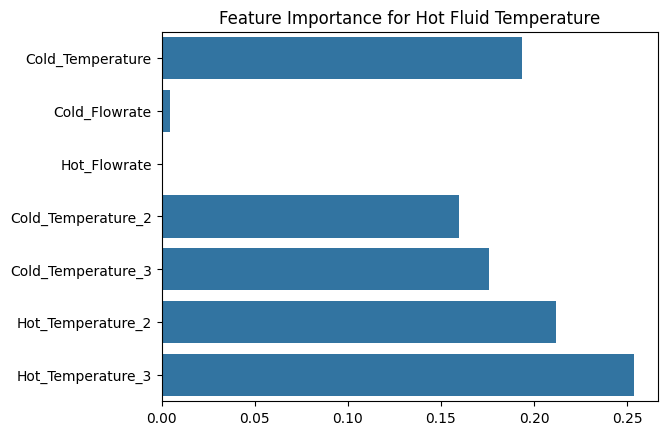

In [63]:
# Define features and target
features = ['Cold_Temperature', 'Cold_Flowrate', 'Hot_Flowrate', 'Cold_Temperature_2', 'Cold_Temperature_3', 'Hot_Temperature_2', 'Hot_Temperature_3']
target = 'Hot_Temperature'

# Drop rows with missing values in the selected columns
df_model = df[features + [target]].dropna()

# Split data into training and testing sets
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
preds = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, preds))

# Feature importance visualization
importances = model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Feature Importance for Hot Fluid Temperature")
plt.show()


In [64]:
# Prepare data for time-based forecast, include 'Elapsed' column
df_temp = df[['Elapsed', 'Hot_Temperature']].dropna()  # Ensure 'Elapsed' is included here

# We already have the 'Elapsed' column representing time in seconds
X_time = df_temp[['Elapsed']]
y_temp = df_temp['Hot_Temperature']

# Fit a linear regression model to predict temperature over time
lin_model = LinearRegression()
lin_model.fit(X_time, y_temp)

# Predict time to reach 55°C
slope = lin_model.coef_[0]
intercept = lin_model.intercept_

if slope > 0:
    time_to_danger = (55 - intercept) / slope
    print(f"Estimated time until 55°C: {round(time_to_danger / 60, 2)} minutes")
else:
    print("Temperature is stable or decreasing — no danger predicted.")


Estimated time until 55°C: 272.02 minutes


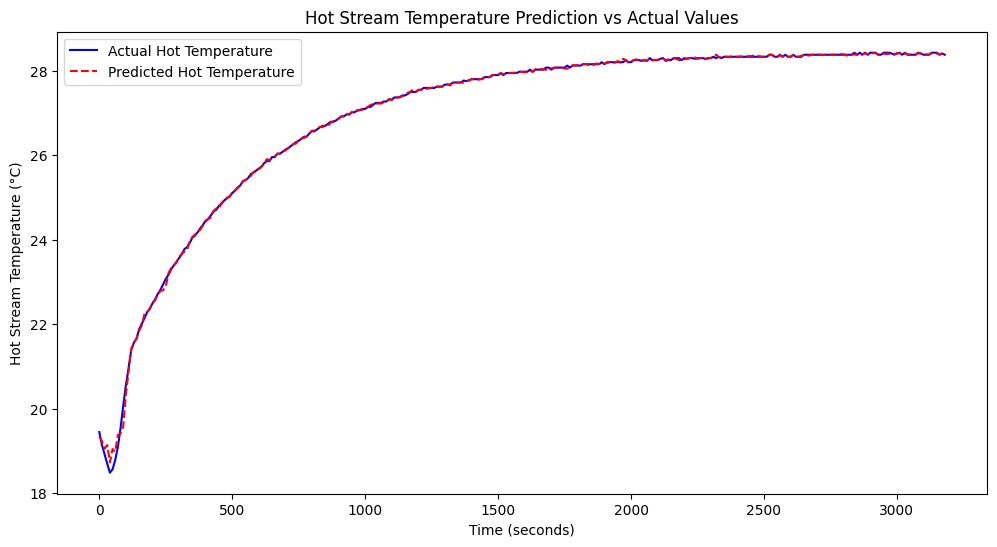

In [65]:
# Plot predictions vs actual values over time
plt.figure(figsize=(12, 6))
plt.plot(df_temp['Elapsed'], df_temp['Hot_Temperature'], label='Actual Hot Temperature', color='b')

# Make sure df_temp has the necessary columns
df_temp_features = df[features].dropna()  # Ensure we drop NaN values for prediction
predicted_hot_temp = model.predict(df_temp_features)

plt.plot(df_temp['Elapsed'], predicted_hot_temp, label='Predicted Hot Temperature', color='r', linestyle='--')
plt.xlabel('Time (seconds)')
plt.ylabel('Hot Stream Temperature (°C)')
plt.title('Hot Stream Temperature Prediction vs Actual Values')
plt.legend()
plt.show()


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load data
url = "https://raw.githubusercontent.com/Bradley1735656/che525Instrumentation/refs/heads/main/Final%20Project%20Data.csv"
df = pd.read_csv(url)

# Rename thje Columns
df.rename(columns={
    'TE-800-13': 'Cold_Temp',
    'FIT-800-01': 'Cold_Flow',
    'FIT-800-02': 'Hot_Flow',
    'TE-800-03': 'Hot_Temp',
    'TE-800-09': 'Cold_Temp_2',
    'TE-800-12': 'Cold_Temp_3',
    'TE-800-15': 'Hot_Temp_2',
    'TE-800-16': 'Hot_Temp_3'
}, inplace=True)

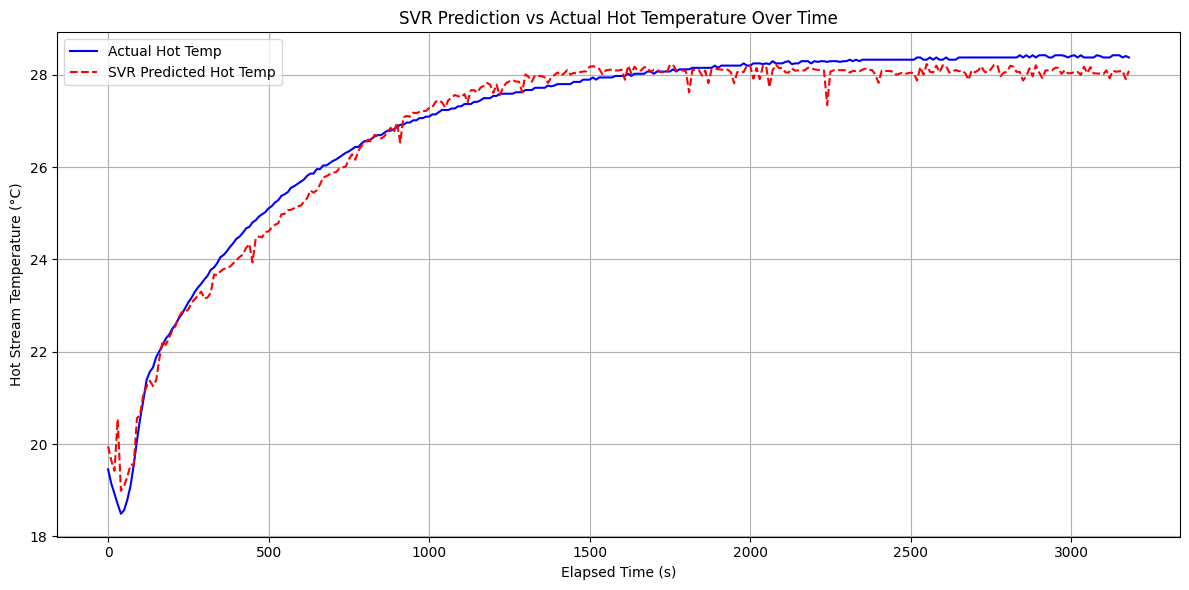

In [75]:

#Plot Creation

plt.figure(figsize=(12, 6))
plt.plot(df_clean['Elapsed'], y, label='Actual Hot Temp', color='blue')
plt.plot(df_clean['Elapsed'], y_pred_full, label='SVR Predicted Hot Temp', color='red', linestyle='--')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Hot Stream Temperature (°C)')
plt.title('SVR Prediction vs Actual Hot Temperature Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [80]:
# Function to predict hot stream temp and time until 55°C
def predict_svr_time_to_55(cold_temp, cold_flow, hot_flow):
    input_data = pd.DataFrame([{
        'Cold_Temp': cold_temp,
        'Cold_Flow': cold_flow,
        'Hot_Flow': hot_flow,
        'Cold_Temp_2': cold_temp,
        'Cold_Temp_3': cold_temp,
        'Hot_Temp_2': 0,
        'Hot_Temp_3': 0
    }])

    # Scale input
    input_scaled = scaler.transform(input_data)
    predicted_temp = svr.predict(input_scaled)[0]

    # Estimate time to 55°C from current predicted temperature using linear trend
    df_time = df_clean[['Elapsed', 'Hot_Temp']].dropna()
    lin_model = np.polyfit(df_time['Elapsed'], df_time['Hot_Temp'], 1)
    slope, intercept = lin_model

    if slope > 0:
        time_to_55 = (55 - predicted_temp) / slope
        return predicted_temp, round(time_to_55 / 60, 2)
    else:
        return predicted_temp, float('inf')

# Example usage
pred_temp, time_left = predict_svr_time_to_55(cold_temp=25, cold_flow=10, hot_flow=12)
print(f"Predicted Hot Temp: {pred_temp:.2f} °C")
print(f"Estimated Time Until 55°C: {time_left:.2f} minutes")

Predicted Hot Temp: 22.80 °C
Estimated Time Until 55°C: 281.69 minutes
